# Install Dependencies

Will require runtime restart to install labelbox and fastai



In [ ]:
!pip install labelbox
!pip install fastai --upgrade

In [ ]:
images_output_dir = '/content/training_data/'

We stored most of our data in archives in Google drive, so mount the Google Drive (only works for Google Collab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
images_archive = '/content/drive/My Drive/480ChevronDrone/image_collection_1-morro_bay.7z'

# Extract shallowly (without directory structure) to make finding the files later easier
# -aos option to automatically skip extracting already extracted images
!7z e "{images_archive}" -o{images_output_dir} -aos

Open the connection to labelbox

In [ ]:
import labelbox

#@title Raw fields
labelbox_api_key = ""#@param {type:"string"}
labelbox_client = labelbox.Client(api_key=labelbox_api_key)
labelbox_project = labelbox_client.get_project("ckgsd9vpqcbfi07551i84k16i")
labelbox_dataset = labelbox_client.get_dataset("ckgy008m67eku0784rld6g3lo")

## Convert labels into paths and classifications

In [ ]:
import json
import urllib.request
from PIL import Image
from pathlib import Path

# Folder for images with unlabeled circles
images_exclude_folder = '/content/training_exclude/'
Path(images_exclude_folder).mkdir(parents=True, exist_ok=True)


# We'll also be creating a dictionary keyed by image path to retrieve bounding
# boxes and classes quickly
img2classifs = {}

for label in labelbox_project.labels():

  # Use the label->dataset relationship to get filename
  image_data = label.data_row()
  file_name = image_data.external_id
  file_path = images_output_dir + file_name
  excluded_path = images_exclude_folder + file_name

  # If we have the image locally (extracted from archive), don't download it
  if Path(file_path).exists():
    pass
  
  # Otherwise, download the image from labelbox
  # Taken from https://stackoverflow.com/questions/7243750/download-file-from-web-in-python-3
  elif not Path(excluded_path).exists():
    print(f"Downloading {file_name}")
    image_url = image_data.row_data
    response = urllib.request.urlretrieve(image_url, file_path)

  # Actual label data is encoded in a JSON string
  label_data = json.loads(label.label)

  # Access label 'objects' (individual items in an image)
  if not Path(excluded_path).exists() and "objects" in label_data:

    # set of classifications for this image
    this_classifs = set()

    label_objects = label_data["objects"]

    #print(f"\t{title}: {value}")

    for label_object in label_objects:
      generic_circle = False

      if "polygon" in label_object:
        object_type = label_object["value"]
        polygon_bounds = label_object["polygon"]

        # If the object is a circular tag, we actually want the individual type of tag for training
        if object_type == 'circular_tag':
          if 'classifications' in label_object:
            object_classifications = label_object['classifications']

            for obj_classif in object_classifications:
              if obj_classif['value'] == 'which_circle?':

                if "answer" in obj_classif:
                  object_type = obj_classif['answer']['value']

          # If the type of the object is still just a generic circular tag,
          # move the file so it won't be included in training
          if object_type == 'circular_tag':
            generic_circle = True
            print("WARN: Automatically excluding image with unlabeled circle tag")
            !mv {file_path} {excluded_path}
            break

        # Break out of this label entirely if we found an unlabeled circle tag
        if object_type == 'circular_tag':
          break
        
        # Add this bounding box (and its classification) to the list of objects
        # for this image
        this_classifs.add(object_type)

    # Only append to the annotation list if there was at least one object in the image
    # Above fact discovered through painful and extensive trial and error
    if not generic_circle:

      classifs_string = " ".join(this_classifs)
      # Add the bounding box to the dict for lookup
      img2classifs[file_path] = classifs_string

      print(f"{file_name}: \"{classifs_string}\"")

img2classifs

In [ ]:
with open("/content/annotations.json", "w") as outfile:
    json.dump(img2classifs, outfile, indent=2)

In [ ]:
import json

with open('/content/annotations.json', 'r') as annotations_json:
      img2classifs = json.load(annotations_json)
img2classifs

# Create the FastAI DataBlock

To train a model using fastai, we have to put the data in a format that 

In [ ]:
from fastai.vision.all import *

In [ ]:
def get_image_path(img):
  return img

def get_image_classes(img):
  classifs = img2classifs.get(img)
  if classifs is None:
    return []
  else:
    return classifs.split()

In [ ]:
pascal_datablock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                             splitter=RandomSplitter(),
                             get_x=get_image_path,
                             get_y=get_image_classes,
                             item_tfms = Resize(512, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                             batch_tfms=aug_transforms(size=512, pad_mode=PadMode.Zeros))

In [ ]:
dls = pascal_datablock.dataloaders(img2classifs.keys(), bs=8)

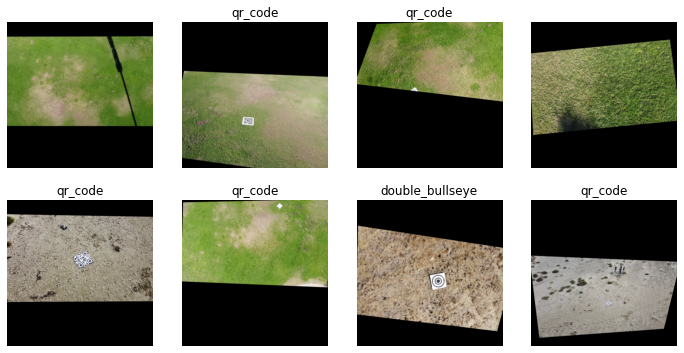

In [ ]:
dls.show_batch()

In [ ]:
with open("/content/validation_images.json", 'w') as validation_json:
  json.dump(dls.valid_ds.items, validation_json,  indent=2)

with open("/content/training_images.json", 'w') as validation_json:
  json.dump(dls.train_ds.items, validation_json,  indent=2)

Download the resnet50 architecture and create a model learner using the architecture

In [ ]:
learner = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


We use a FastAI function to find the optimal learning rate for resnet50 on this dataset, which lowers training time without compromising accuracy

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=1.5848931980144698e-06)

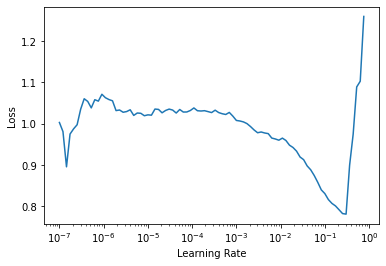

In [ ]:
torch.cuda.empty_cache()
learner.lr_find()

Train the ResNet architecture with our new data and the 

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.346580,0.340589,0.905797,05:40


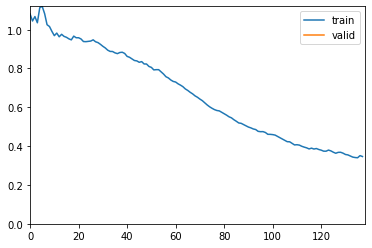

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.199376,0.234458,0.930435,05:34
1,0.169748,0.160043,0.945652,05:33
2,0.195657,1.644226,0.907246,05:34
3,0.183043,0.166050,0.952174,05:30
4,0.166439,0.123149,0.959420,05:32
5,0.140522,0.108461,0.970290,05:31
6,0.120690,0.099489,0.967391,05:25
7,0.102064,0.096754,0.970290,05:24
8,0.081395,0.082522,0.974638,05:27
9,0.067891,0.077289,0.973913,05:24


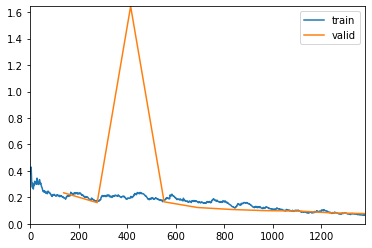

In [ ]:
learner.fine_tune(10, 1.4e-2, cbs=[ShowGraphCallback()])

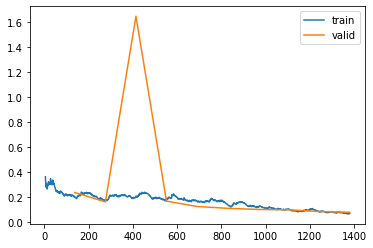

In [ ]:
learner.recorder.plot_loss(with_valid=True)

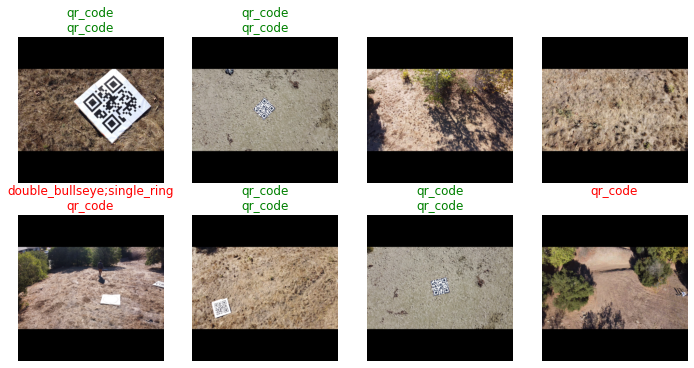

In [ ]:
learner.show_results()

In [ ]:
learner.predict('/content/training_exclude/DJI_0316-0h1m0s460.png')

((#2) ['bullseye','single_dot'],
 tensor([ True, False, False,  True, False]),
 tensor([0.5450, 0.0477, 0.4143, 0.9869, 0.0406]))

In [ ]:
learner.save('/content/drive/MyDrive/480ChevronDrone/models/third-multiclass.pth')
learner.export('/content/drive/MyDrive/480ChevronDrone/models/third-multiclass.pkl')

Test the model on the validation set and return the error rate/accuracy

In [ ]:
learner.validate()

(#2) [0.0772891566157341,0.9739131331443787]